Import libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as SKLDA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score
from scipy import stats

Data Loading & Target Encoding

In [2]:
sns.set_style("whitegrid")
try:
    df = pd.read_csv('AswanData_weatherdata.csv')
except FileNotFoundError:
    print("Error: 'AswanData_weatherdata.csv' not found. Please ensure the file is correctly placed.")
    exit()

df = df.drop('Date', axis=1)
df['Solar_Class'] = pd.qcut(df['Solar(PV)'], q=3, labels=['Low', 'Medium', 'High'])
df = df.drop('Solar(PV)', axis=1)

X = df.drop('Solar_Class', axis=1)
y = df['Solar_Class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print(f"Target classes encoded: {le.classes_}")

Target classes encoded: ['High' 'Low' 'Medium']


Data Cleaning & Statistical Summary

In [3]:
print("\n--- Missing Values ---")
print(X.isnull().sum())
for col in X.columns:
    if X[col].isnull().any():
        X[col].fillna(X[col].mean(), inplace=True)

print("\n--- Descriptive Statistics ---")
print(X.describe())

print("\n--- Skewness and Kurtosis ---")
print(X.skew())
print(X.kurt())


--- Missing Values ---
Unnamed: 0                        0
AvgTemperture                     0
AverageDew(point via humidity)    0
Humidity                          0
Wind                              0
Pressure                          0
dtype: int64

--- Descriptive Statistics ---
       Unnamed: 0  AvgTemperture  AverageDew(point via humidity)    Humidity  \
count  398.000000     398.000000                      398.000000  398.000000   
mean   211.439698      81.846482                       36.754020   22.968090   
std    122.655628      13.613097                        8.906835    9.756598   
min      0.000000      51.100000                       15.300000    7.400000   
25%    102.250000      70.850000                       29.625000   15.625000   
50%    215.500000      85.050000                       37.250000   20.500000   
75%    315.750000      93.400000                       44.000000   28.975000   
max    421.000000     102.700000                       63.900000   47.70000

Correlation, Covariance & ANOVA Analysis


--- Covariance Matrix ---
                                  Unnamed: 0  AvgTemperture  \
Unnamed: 0                      15044.403156     708.645757   
AvgTemperture                     708.645757     185.316398   
AverageDew(point via humidity)    524.977699      56.149939   
Humidity                         -182.746639     -97.565591   
Wind                              118.277384       4.516890   
Pressure                           -4.552348      -1.498763   

                                AverageDew(point via humidity)    Humidity  \
Unnamed: 0                                          524.977699 -182.746639   
AvgTemperture                                        56.149939  -97.565591   
AverageDew(point via humidity)                       79.331709   19.683340   
Humidity                                             19.683340   95.191196   
Wind                                                  7.761021    2.206180   
Pressure                                             -0.363049 

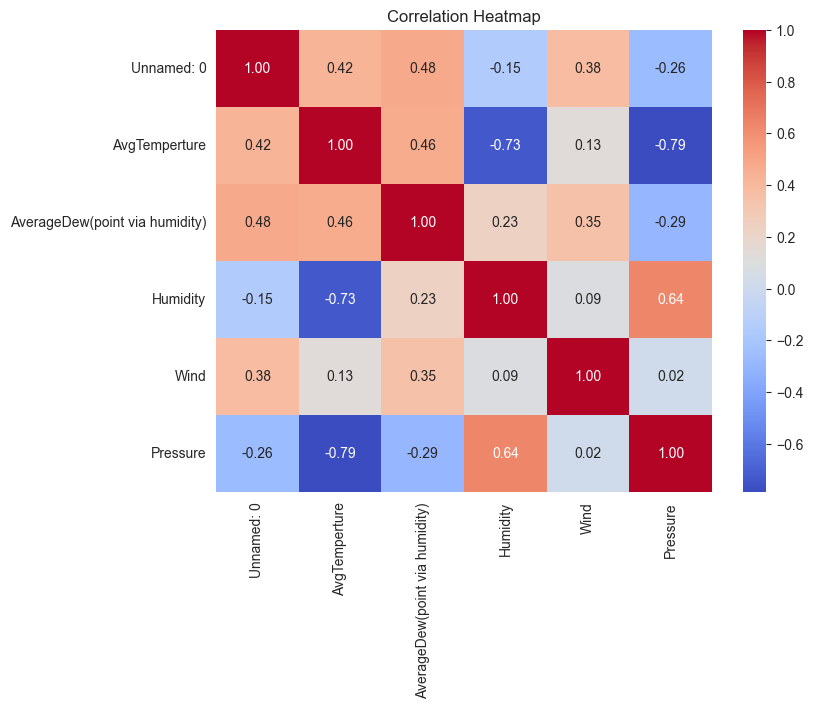


--- ANOVA Tests (Feature vs. Solar_Class) ---
ANOVA for Unnamed: 0: F-stat=110.3854, P-value=0.0000
ANOVA for AvgTemperture: F-stat=3.3896, P-value=0.0347
ANOVA for AverageDew(point via humidity): F-stat=0.6144, P-value=0.5415
ANOVA for Humidity: F-stat=5.5064, P-value=0.0044
ANOVA for Wind: F-stat=16.3466, P-value=0.0000
ANOVA for Pressure: F-stat=0.9687, P-value=0.3805


In [4]:
print("\n--- Covariance Matrix ---")
print(X.cov())
print("\n--- Correlation Matrix ---")
corr_matrix = X.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

print("\n--- ANOVA Tests (Feature vs. Solar_Class) ---")
for col in X.columns:
    try:
        groups = [df[df['Solar_Class'] == name][col] for name in class_names]
        f_stat, p_value = stats.f_oneway(*groups)
        print(f"ANOVA for {col}: F-stat={f_stat:.4f}, P-value={p_value:.4f}")
    except ValueError as e:
        print(f"Could not perform ANOVA for {col}: {e}")

PCA & LDA Dimensionality Reduction

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"\nPCA Explained Variance (2 components): {pca.explained_variance_ratio_.sum():.4f}")

lda_sk = SKLDA(n_components=2)
X_lda = lda_sk.fit_transform(X_scaled, y_encoded)
print(f"LDA Discriminability components created: {X_lda.shape[1]}")


PCA Explained Variance (2 components): 0.7426
LDA Discriminability components created: 2


Train/Test Split & Model Setup

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

models = {
    'Naive Bayesian': GaussianNB(),
    'Decision Tree (Entropy)': DecisionTreeClassifier(criterion='entropy', random_state=42),
    'K-NN (Euclidean)': KNeighborsClassifier(n_neighbors=5, p=2),
    'K-NN (Manhattan)': KNeighborsClassifier(n_neighbors=5, p=1),
    'LDA Classifier': SKLDA(),
    'PCA + K-NN': KNeighborsClassifier(n_neighbors=5),
}
results = {}
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

print("\n--- 5. MODEL IMPLEMENTATION AND EVALUATION ---")


--- 5. MODEL IMPLEMENTATION AND EVALUATION ---


Model Training, Evaluation & ROC Curves


--- Model: Naive Bayesian ---
K-fold Cross-Validation Avg Accuracy: 0.5540
Test Accuracy: 0.5000, Error Rate: 0.5000
Classification Report:
               precision    recall  f1-score   support

        High       0.54      0.74      0.62        27
         Low       0.53      0.37      0.43        27
      Medium       0.42      0.38      0.40        26

    accuracy                           0.50        80
   macro avg       0.49      0.50      0.49        80
weighted avg       0.50      0.50      0.49        80



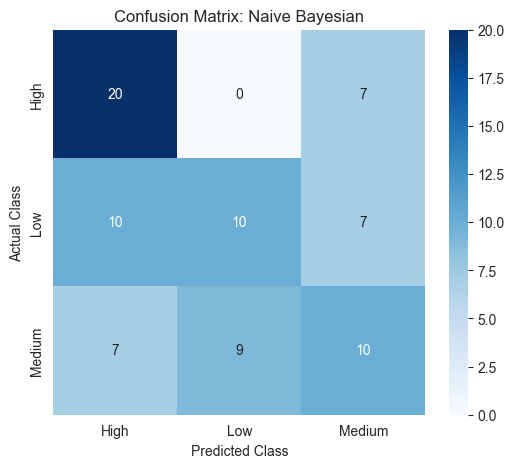

Training Accuracy: 0.5786
Overfitting Analysis: Potential Underfitting (Low Acc)


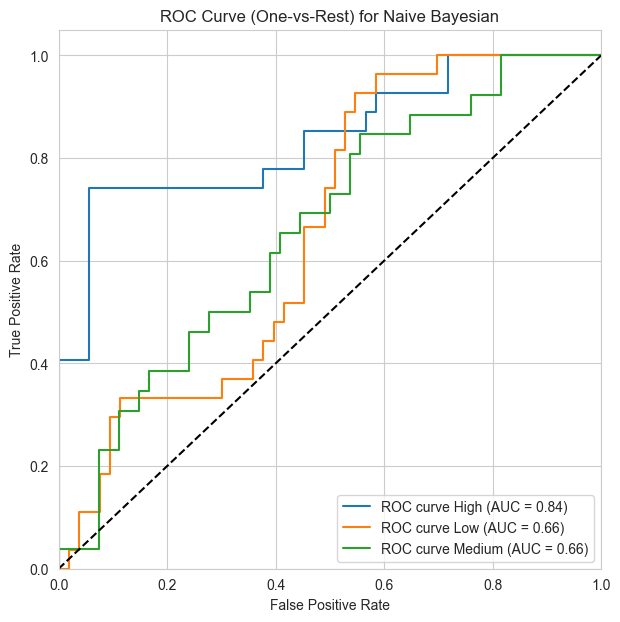


--- Model: Decision Tree (Entropy) ---
K-fold Cross-Validation Avg Accuracy: 0.7739
Test Accuracy: 0.8000, Error Rate: 0.2000
Classification Report:
               precision    recall  f1-score   support

        High       0.96      0.89      0.92        27
         Low       0.73      0.89      0.80        27
      Medium       0.73      0.62      0.67        26

    accuracy                           0.80        80
   macro avg       0.80      0.80      0.80        80
weighted avg       0.81      0.80      0.80        80



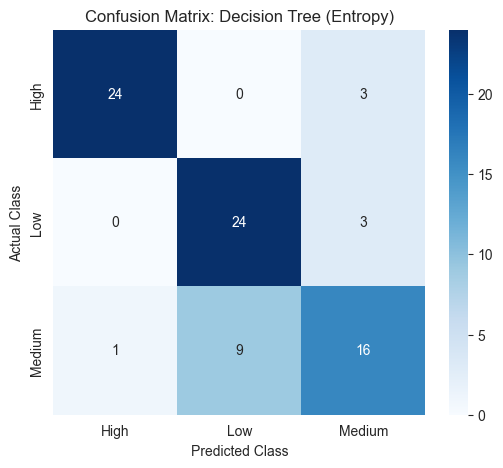

Training Accuracy: 1.0000
Overfitting Analysis: Potential Overfitting (Train Acc >> Test Acc)


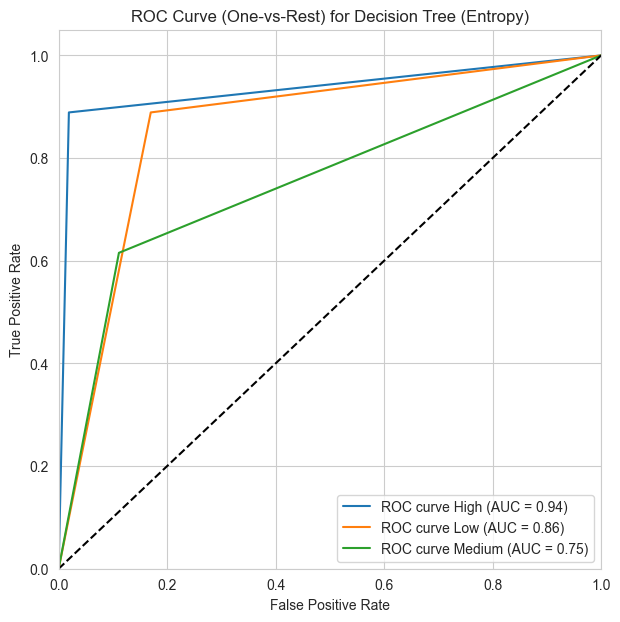


--- Model: K-NN (Euclidean) ---
K-fold Cross-Validation Avg Accuracy: 0.6223
Test Accuracy: 0.7250, Error Rate: 0.2750
Classification Report:
               precision    recall  f1-score   support

        High       0.88      0.81      0.85        27
         Low       0.64      0.85      0.73        27
      Medium       0.68      0.50      0.58        26

    accuracy                           0.72        80
   macro avg       0.73      0.72      0.72        80
weighted avg       0.73      0.72      0.72        80



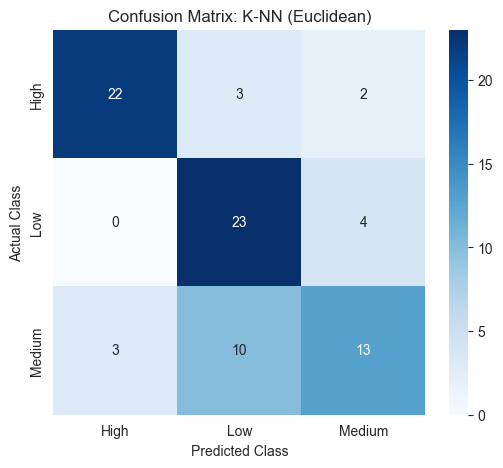

Training Accuracy: 0.7264
Overfitting Analysis: Balanced (Train Acc ≈ Test Acc)


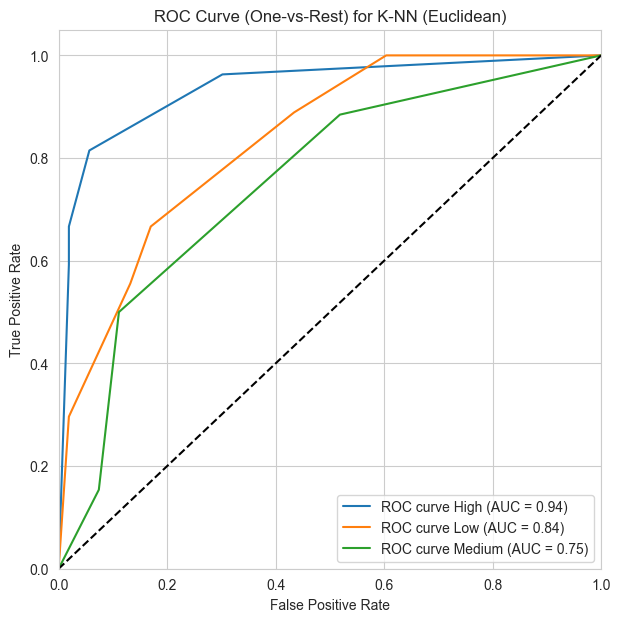


--- Model: K-NN (Manhattan) ---
K-fold Cross-Validation Avg Accuracy: 0.6382
Test Accuracy: 0.6375, Error Rate: 0.3625
Classification Report:
               precision    recall  f1-score   support

        High       0.84      0.78      0.81        27
         Low       0.56      0.74      0.63        27
      Medium       0.53      0.38      0.44        26

    accuracy                           0.64        80
   macro avg       0.64      0.63      0.63        80
weighted avg       0.64      0.64      0.63        80



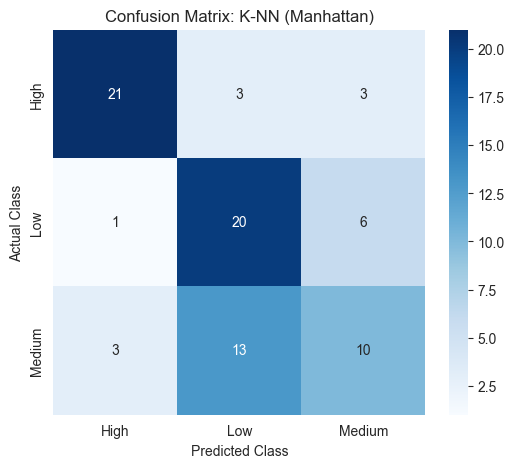

Training Accuracy: 0.7547
Overfitting Analysis: Potential Overfitting (Train Acc >> Test Acc)


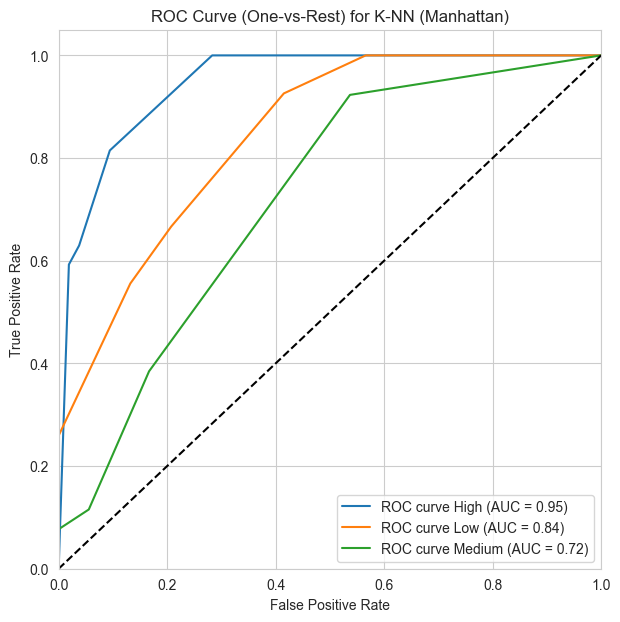


--- Model: LDA Classifier ---
K-fold Cross-Validation Avg Accuracy: 0.6133
Test Accuracy: 0.6375, Error Rate: 0.3625
Classification Report:
               precision    recall  f1-score   support

        High       0.84      0.78      0.81        27
         Low       0.56      0.67      0.61        27
      Medium       0.52      0.46      0.49        26

    accuracy                           0.64        80
   macro avg       0.64      0.64      0.64        80
weighted avg       0.64      0.64      0.64        80



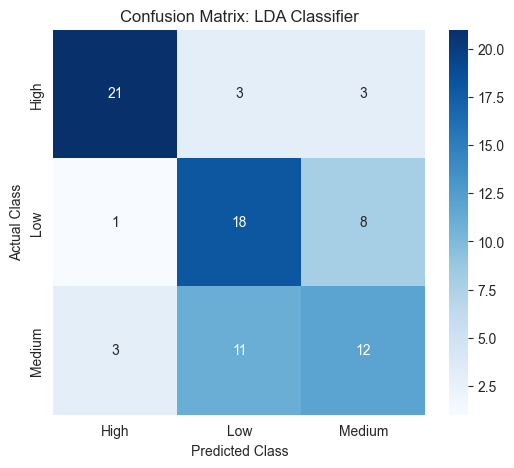

Training Accuracy: 0.6195
Overfitting Analysis: Balanced (Train Acc ≈ Test Acc)


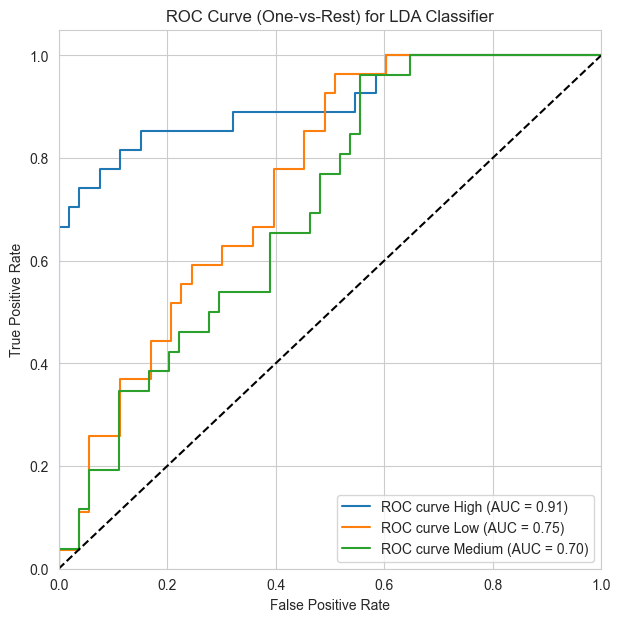


--- Model: PCA + K-NN ---
K-fold Cross-Validation Avg Accuracy: 0.4469
Test Accuracy: 0.5375, Error Rate: 0.4625
Classification Report:
               precision    recall  f1-score   support

        High       0.52      0.59      0.55        27
         Low       0.53      0.67      0.59        27
      Medium       0.60      0.35      0.44        26

    accuracy                           0.54        80
   macro avg       0.55      0.54      0.53        80
weighted avg       0.55      0.54      0.53        80



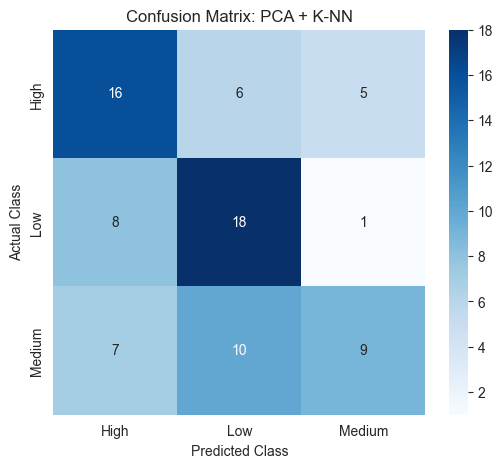

Training Accuracy: 0.6195
Overfitting Analysis: Potential Underfitting (Low Acc)


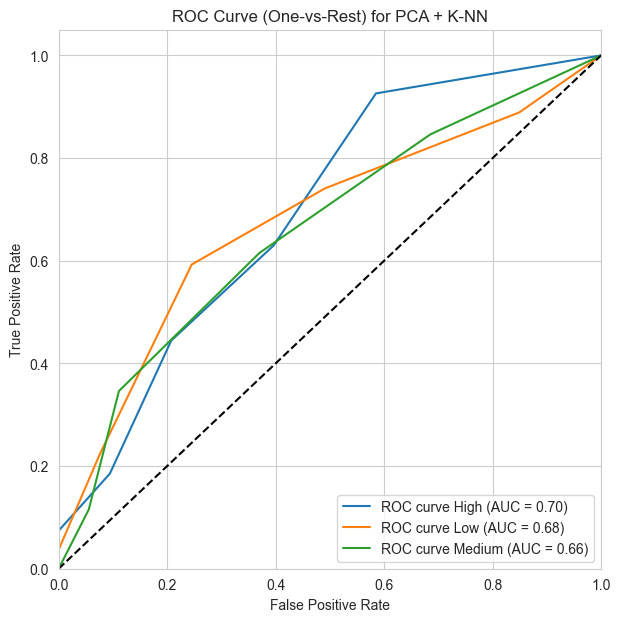

In [7]:
for name, model in models.items():
    print(f"\n--- Model: {name} ---")

    if 'PCA' in name:
        X_train_model = PCA(n_components=2).fit_transform(X_train)
        X_test_model = PCA(n_components=2).fit(X_train).transform(X_test)
        cv_scores = cross_val_score(model, X_train_model, y_train, cv=kfold, scoring='accuracy')
    elif 'LDA Classifier' in name:
        X_train_model = SKLDA(n_components=2).fit_transform(X_train, y_train)
        X_test_model = SKLDA(n_components=2).fit(X_train, y_train).transform(X_test)
        cv_scores = cross_val_score(model, X_train_model, y_train, cv=kfold, scoring='accuracy')
    else:
        X_train_model = X_train
        X_test_model = X_test
        cv_scores = cross_val_score(model, X_train_model, y_train, cv=kfold, scoring='accuracy')

    results[name] = {'CV_Accuracy': cv_scores.mean()}
    print(f"K-fold Cross-Validation Avg Accuracy: {cv_scores.mean():.4f}")

    model.fit(X_train_model, y_train)
    y_pred = model.predict(X_test_model)

    acc = accuracy_score(y_test, y_pred)
    err_rate = 1 - acc
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True, zero_division=0)

    results[name].update({
        'Test_Accuracy': acc,
        'Error_Rate': err_rate,
        'Precision': report['macro avg']['precision'],
        'Recall': report['macro avg']['recall'],
        'F1_Score': f1,
    })

    print(f"Test Accuracy: {acc:.4f}, Error Rate: {err_rate:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

    cm = confusion_matrix(y_test, y_pred)
    results[name]['Confusion_Matrix'] = cm
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

    train_acc = model.score(X_train_model, y_train)
    print(f"Training Accuracy: {train_acc:.4f}")
    if (train_acc - acc) > 0.1:
        results[name]['Overfit_Analysis'] = "Potential Overfitting (Train Acc >> Test Acc)"
    elif acc < 0.6:
        results[name]['Overfit_Analysis'] = "Potential Underfitting (Low Acc)"
    else:
        results[name]['Overfit_Analysis'] = "Balanced (Train Acc ≈ Test Acc)"
    print(f"Overfitting Analysis: {results[name]['Overfit_Analysis']}")

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_model)
        plt.figure(figsize=(7, 7))
        for i, class_name in enumerate(class_names):
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'ROC curve {class_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (One-vs-Rest) for {name}')
        plt.legend(loc="lower right")
        plt.show()


Probabilistic Prediction using GaussianNB

In [9]:
print("\n--- Probabilistic Model using Gaussian Naive Bayes (Sklearn) ---")
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_nb = gnb.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

# --- FIXED SAMPLE PREDICTION ---
# Use mean of each feature column
sample_input = X_train.mean(axis=0).reshape(1, -1)


print("\nSample Input (mean of features):")
print(sample_input)

prob_pred = gnb.predict_proba(sample_input)
print("\nPredicted probabilities for sample input:", prob_pred)


--- Probabilistic Model using Gaussian Naive Bayes (Sklearn) ---
Test Accuracy: 0.5

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.74      0.62        27
           1       0.53      0.37      0.43        27
           2       0.42      0.38      0.40        26

    accuracy                           0.50        80
   macro avg       0.49      0.50      0.49        80
weighted avg       0.50      0.50      0.49        80


Confusion Matrix:
[[20  0  7]
 [10 10  7]
 [ 7  9 10]]

Sample Input (mean of features):
[[ 0.00462518 -0.01830253  0.02061699  0.03325501  0.00858154  0.02903454]]

Predicted probabilities for sample input: [[0.29749586 0.34110536 0.36139879]]


Final Comparison of All Models


--- FINAL MODEL COMPARISON TABLE ---
                        Test_Accuracy  F1_Score Error_Rate
Decision Tree (Entropy)           0.8  0.796581        0.2
K-NN (Euclidean)                0.725   0.71803      0.275
K-NN (Manhattan)               0.6375  0.629019     0.3625
LDA Classifier                 0.6375  0.635886     0.3625
PCA + K-NN                     0.5375  0.526971     0.4625
Naive Bayesian                    0.5  0.486594        0.5


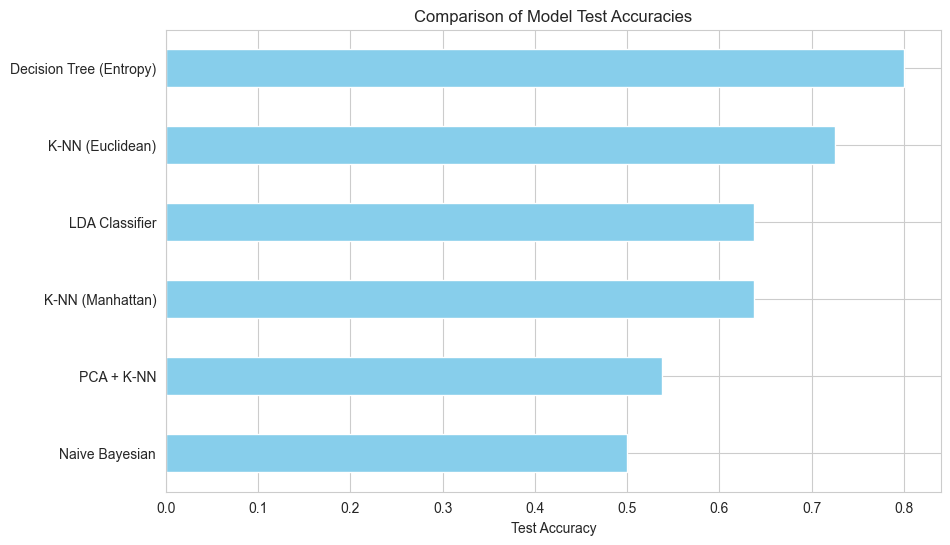

In [10]:
comparison_df = pd.DataFrame({k: v for k, v in results.items() if 'Test_Accuracy' in v}).T[['Test_Accuracy', 'F1_Score', 'Error_Rate']]
comparison_df = comparison_df.dropna()

print("\n--- FINAL MODEL COMPARISON TABLE ---")
print(comparison_df.sort_values(by='Test_Accuracy', ascending=False))

plt.figure(figsize=(10, 6))
comparison_df['Test_Accuracy'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Comparison of Model Test Accuracies')
plt.xlabel('Test Accuracy')
plt.show()